In [2]:
from joblib import Parallel, delayed
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from tensorflow import keras
from keras import layers
import keras_tuner
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from scipy.stats import ttest_ind
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_score
from scikeras.wrappers import KerasClassifier
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
# XGBoost
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz, plot_tree

print("XGBoost version:",xgboost.__version__)

mycmap = "winter"
mpl.rcParams['image.cmap'] = mycmap
plt.rcParams['font.size'] = 13

XGBoost version: 3.0.0


In [3]:
np.random.seed(12345)

dname="./DATA/"
str0="_XGB_25.dat"
fnamex=dname+'x'+str0
fnamey=dname+'y'+str0
x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
y = np.loadtxt(fnamey)
y = y.astype(int)
N,L = len(x), len(x[0])

N_train = int(0.75*N)
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]

print(f"N={N}, N_train={N_train}, L={L}")


early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to watch (commonly 'val_loss' or 'val_accuracy')
    patience=100,         # Number of epochs to wait before stopping if no improvement
    restore_best_weights=True  # Restore the best model weights
)

N=5000, N_train=3750, L=4


[-31.608 -29.544   6.773   9.554] 0
[46.451 15.318 24.891 15.357] 0
[ 24.771  46.131 -49.161 -39.356] 0
[-20.13   15.641  30.981  37.218] 0
[46.465 22.369 14.248 21.745] 0


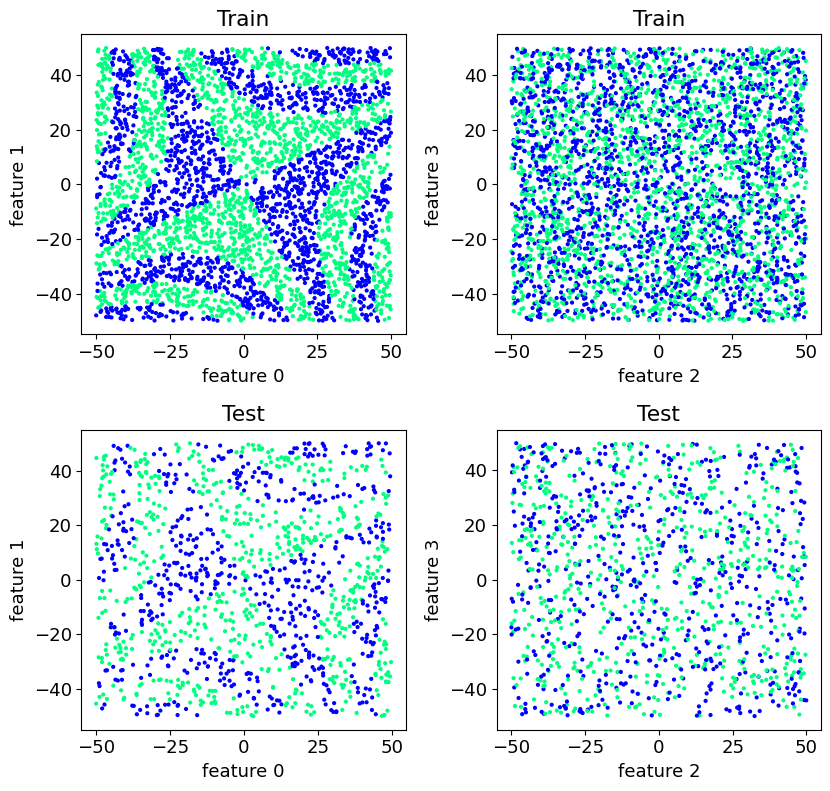

In [4]:
def scat(ax,x,y,i=0,j=1,s=4,title=""):
    ax.scatter(x[:,i],x[:,j],s=s,c=y)
    ax.set_xlabel(f"feature {i}")
    ax.set_ylabel(f"feature {j}")
    ax.set_title(title)

for n in range(5):
    print(x[n],y[n])

fig,AX = plt.subplots(2,2,figsize=(8.5,8.1))
scat(AX[0,0],x_train,y_train,title="Train")
scat(AX[0,1],x_train,y_train,i=2,j=3,title="Train")
scat(AX[1,0],x_test,y_test,title="Test")
scat(AX[1,1],x_test,y_test,i=2,j=3,title="Test")
fig.tight_layout()
plt.show()

In [5]:
def classify(clf=GradientBoostingClassifier(), show=False, ffnn=False, ax_compare=None, title=None, show_tree=False, x_train = x_train, y_train = y_train, x_test = x_test, y_test = y_test, Debug = 0):
    # GradientBoostingClassifier():
    #   n_estimators = 100 (default)
    #   loss function = deviance(default) used in Logistic Regression
    # XGBClassifier()
    #   n_estimators = 100 (default)
    #   max_depth = 3 (default?)

    nepoch = 300

    if ffnn:
        clf.fit(x_train, y_train, epochs = nepoch, batch_size = 20, validation_data = (x_test, y_test), callbacks=[early_stopping], verbose=Debug)
        y_hat = clf.predict(x_test, verbose=Debug)
    else:
        clf.fit(x_train,y_train)
        y_hat = clf.predict(x_test)

    if ffnn:
        errors=(1-clf.evaluate(x_test, y_test, verbose=0)[-1])
        accuracy=clf.evaluate(x_test, y_test, verbose=0)[-1]
    else:
        errors=(1-clf.score(x_test, y_test))
        accuracy=clf.score(x_test, y_test)

    if show and title==None: print("errors: {:.2f}%   Accuracy={:.3f}".format(100*errors,accuracy))
    S=50
    dx = 1
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,L))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:2] = [x_seq[i],x_seq[j]]
            q+=1

    if show:
        if ffnn:
            y_plot= clf.predict(x_plot,verbose=0)
        else:
            y_plot= clf.predict(x_plot)
        #fig,AX = plt.subplots(1,2,figsize=(8.2,4))
        if title != None and ax_compare != None:
            #fig_compare,AX = plt.subplots(1,1,figsize=(3,3))
            scat(ax_compare,x_plot[:],y_plot,s=dx,title=title)
            #plt.close()
        else:
            fig,AX = plt.subplots(1,2,figsize=(8.2,4))
            scat(AX[0],x_plot[:],y_plot,s=dx,title="predicted")
            scat(AX[1],x_train[:],y_train,title="training set")
            fig.tight_layout()
            plt.show()

    if show_tree:
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)

        fig, AX = plt.subplots(2,1,figsize=(12, 5))
        for i in range(min(2,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=400, pad_inches=0.02)
        plt.show()

    if title == None:
        return errors,accuracy

### Classify
If the “objective” hyperparameter is left unspecified, XGBClassifier looks at the data and chooses automatically the loss functions and the evaluation metrics (--> WARNING)

## XGBoost
https://xgboost.readthedocs.io/en/stable/python/python_api.html

errors: 6.64%   Accuracy=0.934


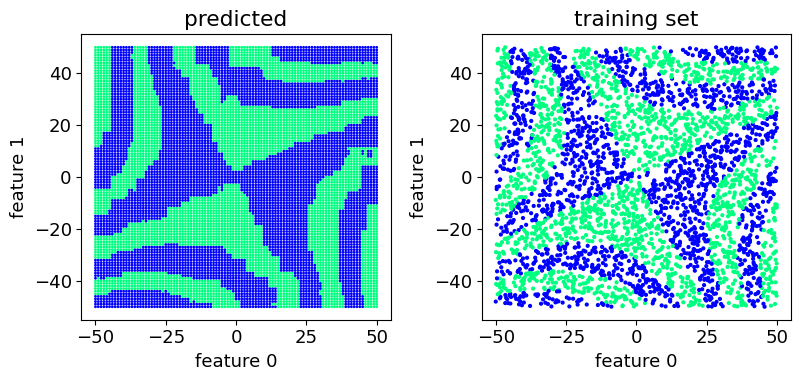

(0.06640000000000001, 0.9336)

In [6]:
model = XGBClassifier(seed=1,
                      objective='binary:logistic',
                      importance_type="gain") #weight, cover, ...
       # learning_rate=0.4,
       # reg_lambda=0.001,
       # n_estimators=30)

classify(model, show=True)

gain
[0.41903338 0.4430613  0.06554136 0.07236398]


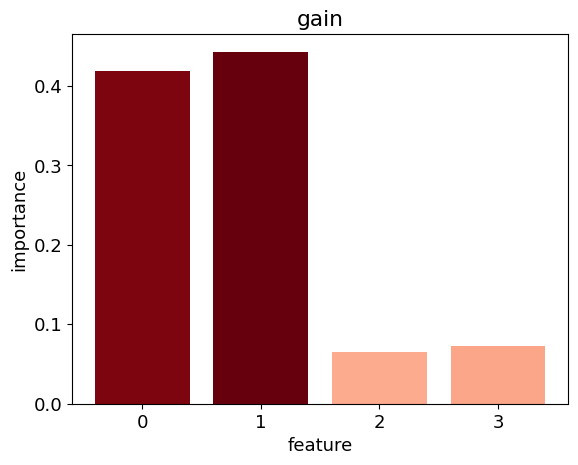

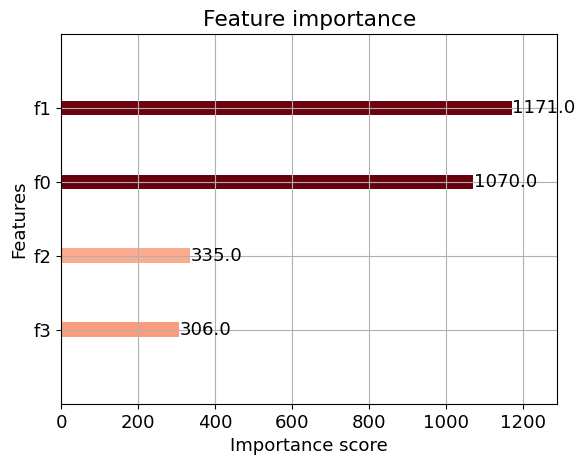

In [7]:
# https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
# feature importance

print(model.importance_type)
print(model.feature_importances_)
# plot
my_cmap = plt.get_cmap("Reds")
rescale = lambda y: 0.3 + 0.7 * (y - np.min(y)) / (np.max(y) - np.min(y))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_,
        color=my_cmap(rescale(model.feature_importances_)))
plt.xlabel("feature")
plt.ylabel("importance")
plt.xticks(np.arange(L))
plt.title(model.importance_type)
plt.show()

rescale_r = lambda y: 0.3 + 0.7 * (np.max(y) - y) / (np.max(y) - np.min(y))
plot_importance(model,color=my_cmap(rescale_r(model.feature_importances_)))
plt.show()

Documentation: https://xgboost.readthedocs.io/en/stable/python/python_api.html

    ‘weight’: the number of times a feature is used to split the data across all trees.

    ‘gain’: the average gain across all splits the feature is used in.

    ‘cover’: the average coverage across all splits the feature is used in.

    ‘total_gain’: the total gain across all splits the feature is used in.

    ‘total_cover’: the total coverage across all splits the feature is used in.


0 weight [1070. 1171.  335.  306.]
1 gain [3.84043241 4.06064796 0.6006853  0.66321445]
2 total_gain [4109.26269531 4755.01855469  201.22958374  202.94361877]
3 cover [73.71099854 66.86531067 77.84243011 62.61100388]
4 total_cover [78870.765625   78299.28125    26077.21289062 19158.96679688]


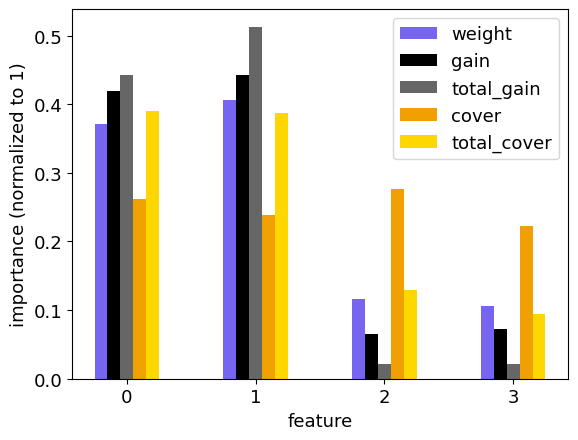

In [8]:
# if the importance type is “total_gain”, then the score is sum of loss change for each split from all trees.
list_type=["weight","gain","total_gain","cover","total_cover"]
list_col=["#7565F0","k","#666666","#F0A000","gold"]

for i,t in enumerate(list_type):
    feature_imp = model.get_booster().get_score(importance_type=t)
    keys = list(feature_imp.keys())
    values = np.array(list(feature_imp.values()))
    print(i,t,values)
    values= values/np.sum(values)
    plt.bar(np.arange(L)+(i-L/2)/10, values,color=list_col[i],width=0.1,label=t)
plt.xlabel("feature")
plt.ylabel("importance (normalized to 1)")
plt.xticks(np.arange(L))
plt.legend()
plt.show()

## normal Gradient Boosting

errors: 19.76%   Accuracy=0.802


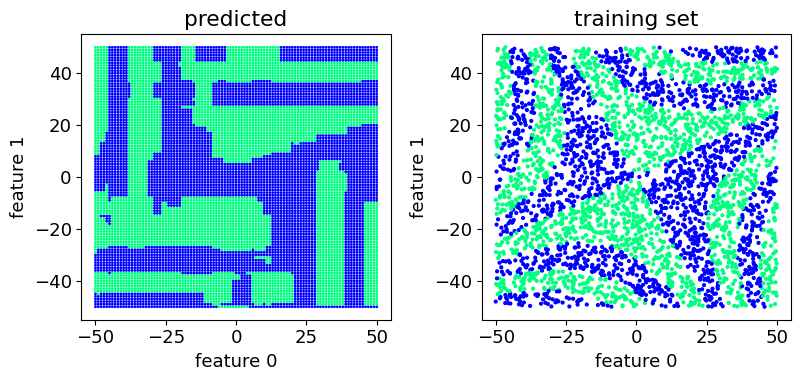

(0.1976, 0.8024)

In [9]:
# GradientBoostingClassifier()
classify(show = True)

## AdaBoost

In [10]:
classify(clf=AdaBoostClassifier(learning_rate=.8,n_estimators=150))

(0.4072, 0.5928)

# 1. Model complexity, parameters and regularization

In [11]:
def make_and_test_xgb_model(importance_type="gain", learning_rate=0.4 ,reg_lambda=0.001, n_estimators=40, max_depth = 6, gamma = 0):
    model = XGBClassifier(seed=1, 
                          objective='binary:logistic',
                          importance_type="gain",#weight, cover, ...
                          learning_rate=learning_rate,
                          reg_lambda=reg_lambda,
                          n_estimators=n_estimators,
                          max_depth = max_depth,
                          gamma = gamma,
                          n_jobs = -1 )

    err, acc = classify(model)
    return model, acc, err

#### Test varying learning rate and n_range

In [12]:
!mkdir Point_1

mkdir: Point_1: File exists


In [13]:
n_range = np.linspace(10,200,40)
l_range = np.linspace(0.1,1,40)

acc_arr = []
for n in tqdm(n_range, desc = "Processing"):
    acc_row = []
    for l in l_range:
        model, acc, err = make_and_test_xgb_model(importance_type="gain", learning_rate=l ,reg_lambda=0.001, n_estimators=int(n), max_depth = 6, gamma = 0)
        acc_row.append(acc)
    acc_arr.append(acc_row)

f_name = f"Point_1/{float(min(l_range))},{float(max(l_range))},{min(n_range)},{max(n_range)}.npy"
np.save(f_name, acc_arr)
print("File", f_name, "saved correctly")

Processing:  50%|█████     | 20/40 [00:25<00:25,  1.29s/it]


KeyboardInterrupt: 

Code to visualize the saved file

Best accuracy with n_estimators = 44 and learning rate = 0.38


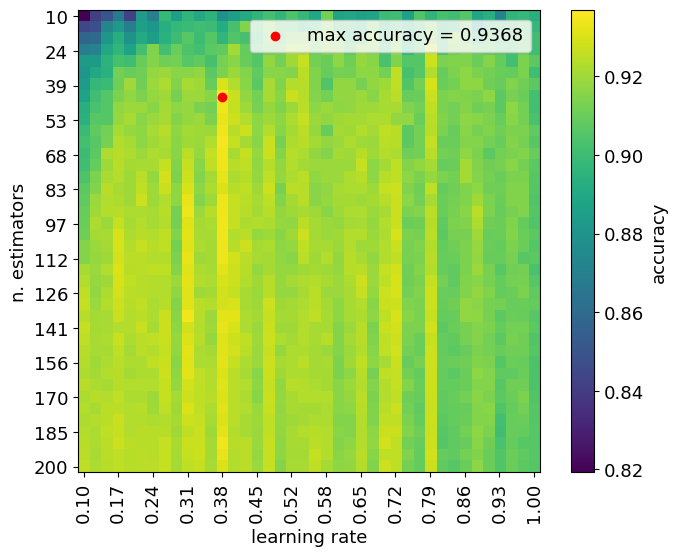

In [17]:
mi_n = 10
ma_n = 200
mi_l = 0.1
ma_l = 1.0

acc_arr_r = np.load(f"Point_1/{mi_l},{ma_l},{float(mi_n)},{float(ma_n)}.npy")

n_range = np.linspace(mi_n,ma_n,len(acc_arr_r), dtype="int")
l_range = np.linspace(mi_l,ma_l,len(acc_arr_r[0]))

max_idx = np.unravel_index(np.argmax(acc_arr_r), acc_arr_r.shape)
max_value = acc_arr_r[max_idx]

best_n_estimators = n_range[max_idx[0]]
best_learning_rate = l_range[max_idx[1]]

print(f"Best accuracy with n_estimators = {best_n_estimators} and learning rate = {best_learning_rate:.2f}")

plt.figure(figsize=(8, 6))
plt.imshow(acc_arr_r, cmap='viridis')
plt.colorbar(label="accuracy", shrink= 1)

plt.scatter(max_idx[1],max_idx[0], color = "r", label = f"max accuracy = {max_value}")

plt.xlabel("learning rate")
plt.ylabel("n. estimators")
plt.yticks(range(len(n_range)), labels=n_range)
plt.xticks(range(len(l_range)), labels=[f'{val:.2f}' for val in l_range], rotation = 90)
xticks = plt.xticks()[0]
yticks = plt.yticks()[0]
plt.xticks(xticks[::3])
plt.yticks(yticks[::3])
plt.legend(loc = "best")

plt.show()

#### Test varying gamma and reg_lambda
We use the best combination founded for the learning rate and n_estimators

In [19]:
mi_g = 0
ma_g = 0.02
mi_la = 0.0001
ma_la = 0.005

g_range = np.linspace(mi_g,ma_g,40)
la_range = np.linspace(mi_la,ma_la,40)

acc_arr = []
for g in tqdm(g_range, desc = "Processing"):
    acc_row = []
    for la in la_range:
        model, acc, err = make_and_test_xgb_model(importance_type="gain", learning_rate=best_learning_rate ,reg_lambda=la, n_estimators=best_n_estimators, max_depth = 6, gamma = g)
        acc_row.append(acc)
    acc_arr.append(acc_row)

f_name = f"Point_1/{float(min(la_range))},{float(max(la_range))},{min(g_range)},{max(g_range)}_lambda_and_gamma.npy"
np.save(f_name, acc_arr)
print("File", f_name, "saved correctly")

Processing:  10%|█         | 4/40 [00:05<00:45,  1.25s/it]


KeyboardInterrupt: 

In [18]:
acc_arr_r = np.load(f"Point_1/{float(mi_la)},{ma_la},{float(mi_g)},{float(ma_g)}_lambda_and_gamma.npy")

g_range = np.linspace(mi_g,ma_g,len(acc_arr_r))
la_range = np.linspace(mi_la,ma_la,len(acc_arr_r[0]))

max_idx = np.unravel_index(np.argmax(acc_arr_r), acc_arr_r.shape)
max_value = acc_arr_r[max_idx]

best_gamma = g_range[max_idx[0]]
best_lambda = la_range[max_idx[1]]

print(f"Best accuracy with n_estimators = {best_gamma} and learning rate = {best_lambda:.4f}")

plt.figure(figsize=(8, 6))
plt.imshow(acc_arr_r, cmap='viridis')
plt.colorbar(label="accuracy", shrink= 1)

plt.scatter(max_idx[1],max_idx[0], color = "r", label = f"max accuracy = {max_value}")

plt.xlabel("lambda reg.")
plt.ylabel("gamma")
plt.yticks(range(len(g_range)), labels=[f'{val:.4f}' for val in g_range])
plt.xticks(range(len(la_range)), labels=[f'{val:.4f}' for val in la_range], rotation = 90)
xticks = plt.xticks()[0]
yticks = plt.yticks()[0]
plt.xticks(xticks[::3])
plt.yticks(yticks[::3])
plt.legend(loc = "best")

plt.show()

NameError: name 'mi_la' is not defined

### Searching randomly in the hyperparameter space around the best point founded in the previous steps

In [ ]:
np.random.seed(1234)

def search(tra_test, n_test=10):

    "learning_rate=0.4 ,reg_lambda=0.001, n_estimators=40, max_depth = 6, gamma = 0"
    x = [np.array([best_learning_rate ,best_lambda, best_n_estimators, best_gamma])]
    model, acc,_ = tra_test(learning_rate=x[0][0] ,reg_lambda=x[0][1], n_estimators=int(x[0][2]), gamma = x[0][3])
    model_arr = [model]
    acc_arr = [acc]

    for i in tqdm(range(n_test), desc = "Processing"):
        model, acc, _ = tra_test(learning_rate=x[i][0] ,reg_lambda=x[i][1], n_estimators=int(x[i][2]), gamma = x[i][3])
        model_arr.append(model)
        acc_arr.append(acc)
        x.append(np.array([max(0, best_learning_rate + (np.random.uniform()-0.5)*0.05),
                           max(0, best_lambda + (np.random.uniform()-0.5)*0.0005),
                           best_n_estimators + int((np.random.uniform()-0.5)*2),
                           max(0, best_gamma + (np.random.uniform()-0.5)*0.005)]))

    sorted_indices = np.argsort(acc_arr)[::-1]
    model_arr = np.array(model_arr)[sorted_indices]
    acc_arr = np.array(acc_arr)[sorted_indices]
    x = np.array(x)[sorted_indices]
    return model_arr, acc_arr, x

In [ ]:
model_arr, acc_arr, hyper_param = search(make_and_test_xgb_model, n_test = 1000)

In [ ]:
for i in range(5):
    print(f"{acc_arr[i]:.5f}", hyper_param[i])

For me the best model is this --> model_arr[0]

In [23]:
best_accuracy = acc_arr[0]
model = model_arr[0]
hyper_par = hyper_param[0]

NameError: name 'model_arr' is not defined

# 2. Dimensionality reduction
Now we want to observe how the training perform reducing the dimensionality of the feature space.

In [ ]:
fig,AX = plt.subplots(1,2,figsize=(8.5,4.1))
scat(AX[0],x,y,title="Train")
scat(AX[1],x,y,i=2,j=3,title="Train")

fig.tight_layout()
plt.show()

Generate the training and the test set without one of the feature space dimension.

In [21]:
def remove_dim(dim, data = x):
    return np.delete(data, dim, axis = 1)

x_train_0 = remove_dim(0, data = x_train)
x_test_0 = remove_dim(0, data = x_test)
x_train_1 = remove_dim(1, data = x_train)
x_test_1 = remove_dim(1, data = x_test)
x_train_2 = remove_dim(2, data = x_train)
x_test_2 = remove_dim(2, data = x_test)
x_train_3 = remove_dim(3, data = x_train)
x_test_3 = remove_dim(3, data = x_test)

x_train_arr = [x_train_0, x_train_1, x_train_2, x_train_3]
x_test_arr = [x_test_0, x_test_1, x_test_2, x_test_3]

In [22]:
acc_perf_without_feature = []

#Still working on it
x = np.concatenate((x_train,x_test))
y = np.concatenate((y_train,y_test))
##
N = 5
kf = KFold(n_splits=N, shuffle=True, random_state=len(x_train))

for tr,te in zip(x_train_arr, x_test_arr):
    acc_vec = []
    for fold, (train_index, test_index) in enumerate(kf.split(x_train)):
        _, acc = classify(model, x_train = tr[train_index], x_test = te, y_train = y_train[train_index])
        acc_vec.append(acc)
    acc_perf_without_feature.append(acc_vec)

x_labels = ["All f.", "No f. 1", "No f. 2", "No f. 3", "No f. 4"]

acc_perf_without_feature = np.array(acc_perf_without_feature)
men = acc_perf_without_feature.mean(axis = 1)
men = np.insert(men, 0, best_accuracy)
st = acc_perf_without_feature.std(axis = 1)
st = np.insert(st, 0, 0)

plt.errorbar(x_labels, men, yerr=st, linewidth = 0, fmt='o', linestyle='-',capsize=5, zorder = 2)
plt.xlabel("")
plt.ylabel("Accuracy")
plt.grid(zorder = 0)

plt.show()

NameError: name 'best_accuracy' is not defined

As expected removing the first or the second feature of the data results in a sensible worst accuracy respect to the one obtained in the full data case.\
Removing the third or the forth instead slightly change the performance of the model resulting in an accuracy comparable with the original one.

We now exploit the results obtained removing both the third and the forth dimensions.

In [ ]:
x_train_23 = remove_dim(3, data = x_train)
x_test_23 = remove_dim(3, data = x_test)
x_train_23 = remove_dim(2, data = x_train_23)
x_test_23 = remove_dim(2, data = x_test_23)

#x = np.concatenate(())

kf = KFold(n_splits=N, shuffle=True, random_state=len(x_train))

acc_vec = []
for fold, (train_index, test_index) in enumerate(kf.split(x_train)):
    _, acc = classify(model, x_train = x_train_23[train_index], x_test = x_test_23, y_train = y_train[train_index])
    acc_vec.append(acc)


acc_vec = np.array(acc_vec)
menc = np.append(men, acc_vec.mean())
stc = np.append(st, acc_vec.std())

x_labels = ["All f.", "No f. 1", "No f. 2", "No f. 3", "No f. 4", "No f. 3&4"]

plt.errorbar(x_labels, menc, yerr=stc, linewidth = 0, fmt='o', linestyle='-',capsize=5, zorder = 2)
plt.xlabel("")
plt.ylabel("Accuracy")
plt.grid(zorder = 0)

plt.show()

print("\nThe accuracy with the entire dataset is:", best_accuracy,"while the accuracy obtained removing the two last dimensions is:", f"{np.mean(acc_vec):.4f}")

# XGBoost vs NN

## Neural Network

In [5]:
# For a specific model plot the graph of accuracy and loss of the training and the validation/test set
def PlotAccuracyAndLoss(fit):

   fig, AX = plt.subplots(1, 2, figsize = (16,8))

   #fig.suptitle(f"Performance of the {whichModel} model over {whichData} data")

   ax = AX[0]
   ax.plot(fit.history['accuracy'], label="train", c="b", ls="--")
   ax.plot(fit.history['val_accuracy'], label="valid.", c="r")
   ax.set_xlabel('epoch')
   ax.set_ylabel("Accuracy")
   ax.legend()

   ax = AX[1]
   ax.plot(fit.history['loss'],label="train",c="b",ls="--")
   ax.plot(fit.history['val_loss'],label="valid.",c="r")
   ax.set_xlabel('epoch')
   ax.set_ylabel("Loss")
   ax.legend()

   plt.show()

In [7]:
# Fuction to build a FFNN
def build_ffnn( hp ):

    model = keras.Sequential()
    #better way to inizialize the first layer 
    model.add(layers.Input(shape=(L,)))

    # Tune the number of layers of the model
    for i in range(hp.Int("num_layers", 1, 10)):
        #print(f"Adding hidden layer {i} with {hp.Int(f'units_{i}', 10, 30, step=5)} units")  # Debug print
        model.add(layers.Dense(
                #Define the units and the activation functions
                units=hp.Int(f"units_{i}", min_value=5, max_value=40, step=5),
                activation=hp.Choice("activation", ["relu", "sigmoid", "tanh", "elu", 'selu', 'leaky_relu']),
            )
        )
        #Define the dropout values of the model
        model.add(layers.Dropout(rate=hp.Float("dropout", min_value = 0, max_value = 0.2, step = 0.05)))
    #Output layer is composed by 1 neuron since it's classification task
    model.add(layers.Dense(1, activation="sigmoid"))
    #Define the learning rate of the model
    learning_rate = hp.Float("lr", min_value=1e-6, max_value=1e-1, sampling="log")

    model.compile(
        #Define the optimizers of the model
        optimizer=hp.Choice("optimizer", ["adam", "RMSprop", "SGD", 'adamax', 'nadam', 'adagrad']), 
        loss="binary_crossentropy",
        metrics=["accuracy"])
    return model


#After builiding the model we impose the tuning
tuner = keras_tuner.RandomSearch(
    hypermodel = build_ffnn,
    objective = "val_accuracy",
    max_trials = 30,
    executions_per_trial = 1,
    overwrite = True,
)

tuner.search_space_summary()

Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 40, 'step': 5, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh', 'elu', 'selu', 'leaky_relu'], 'ordered': False}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.2, 'step': 0.05, 'sampling': 'linear'}
lr (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'RMSprop', 'SGD', 'adamax', 'nadam', 'adagrad'], 'ordered': False}


In [8]:
nEpochs = 300
tuner.search(x_train, y_train, batch_size = 20, epochs = nEpochs, validation_data=(x_test, y_test), verbose=1)

Trial 30 Complete [00h 00m 34s]
val_accuracy: 0.5264000296592712

Best val_accuracy So Far: 0.9527999758720398
Total elapsed time: 00h 19m 12s


In [9]:
#The tuner returns the model already trained, and we take the 4 best ones
modelsHyperParam = tuner.get_best_hyperparameters(num_trials = 8)
#To see the best hyparameters
print(modelsHyperParam[0].values)

# To save hyperparameters
with open("best_hyperparameters.json", "w") as file:
    json.dump([hp.values for hp in modelsHyperParam], file, indent=4)
# To retrieve the per hyperparameters from the keras_tuner search
#with open("best_hyperparameters.json", 'r') as file:
#    modelsHyperParam = json.load(file)

{'num_layers': 7, 'units_0': 40, 'activation': 'elu', 'dropout': 0.0, 'lr': 0.00014075359714141897, 'optimizer': 'adam', 'units_1': 10, 'units_2': 35, 'units_3': 40, 'units_4': 35, 'units_5': 30, 'units_6': 40, 'units_7': 10, 'units_8': 30, 'units_9': 5}


In [10]:
# cross valitation of the ffnn
def cross_validate_ffnn(x, y, hp, epochs, kfold=5 ):

    kfold = KFold(n_splits=kfold, shuffle=True)
    train_accuracy = []
    val_accuracy   = []
    train_loss     = []
    val_loss       = []

    for train_idx, val_idx in kfold.split(x_train, y_train):
        model = build_ffnn(hp)
        fit_kfold = model.fit(x_train[train_idx], y_train[train_idx], validation_data = (x_train[val_idx],y_train[val_idx]), epochs=epochs, batch_size=50, verbose=0)

        train_accuracy.append( fit_kfold.history['accuracy'] )
        val_accuracy.append  ( fit_kfold.history['val_accuracy'] )
        train_loss.append    ( fit_kfold.history['loss'] )
        val_loss.append      ( fit_kfold.history['val_loss'] )

    return train_accuracy, val_accuracy, train_loss, val_loss

In [11]:
#parallelizzed version

def cross_validate_ffnn(x_train, y_train, hp, epochs, kfold=5, n_jobs=-1):
    kfold = KFold(n_splits=kfold, shuffle=True)

    def train_fold(train_idx, val_idx):
        model = build_ffnn(hp)
        fit_kfold = model.fit(x_train[train_idx], y_train[train_idx],
                              validation_data=(x_train[val_idx], y_train[val_idx]),
                              epochs=epochs, batch_size=50, verbose=0)
        return (fit_kfold.history['accuracy'],
                fit_kfold.history['val_accuracy'],
                fit_kfold.history['loss'],
                fit_kfold.history['val_loss'])

    results = Parallel(n_jobs=n_jobs)(delayed(train_fold)(train_idx, val_idx)
                                      for train_idx, val_idx in kfold.split(x_train, y_train))

    train_accuracy, val_accuracy, train_loss, val_loss = zip(*results)

    return list(train_accuracy), list(val_accuracy), list(train_loss), list(val_loss)

In [12]:
def PlotAccuracyAndLoss(train_acc, val_acc, train_loss, val_loss, num_model, tick, num_k):

    train_acc_mean = np.mean(train_acc,axis=0)
    train_acc_std  = np.std(train_acc,axis=0)/np.sqrt(num_k)

    val_acc_mean = np.mean(val_acc,axis=0)
    val_acc_std  = np.std(val_acc,axis=0)/np.sqrt(num_k)

    train_loss_mean = np.mean(train_loss,axis=0)
    train_loss_std  = np.std(train_loss,axis=0)/np.sqrt(num_k)

    val_loss_mean = np.mean(val_loss,axis=0)
    val_loss_std  = np.std(val_loss,axis=0)/np.sqrt(num_k)

    fig, AX = plt.subplots(1, 2, figsize = (10,4))

    fig.suptitle(f"Performance of FFNN n°{num_model+1}")

    ax = AX[0]
    ax.errorbar( x=np.arange(1,len(train_acc_mean)+1)[::tick], y=train_acc_mean[::tick], yerr=train_acc_std[::tick], label="train", c="b", ls="--" )
    ax.errorbar( x=np.arange(1,len(val_acc_mean)+1)[::tick],   y=val_acc_mean[::tick],   yerr=val_acc_std[::tick], label="valid.", c="r")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.legend()

    ax = AX[1]
    ax.errorbar( x=np.arange(1,len(train_loss_mean)+1)[::tick], y=train_loss_mean[::tick], yerr=train_loss_std[::tick], label="train", c="b", ls="--" )
    ax.errorbar( x=np.arange(1,len(val_loss_mean)+1)[::tick], y=val_loss_mean[::tick], yerr=val_loss_std[::tick], label="valid.", c="r")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.legend()

    plt.tight_layout()
    plt.show()

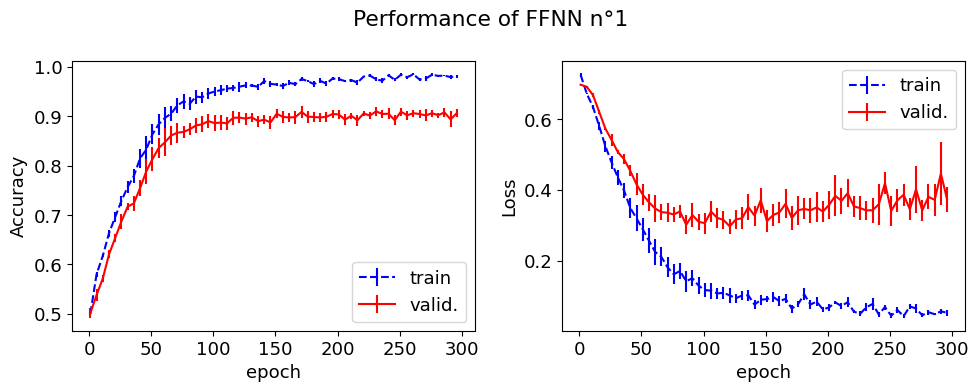

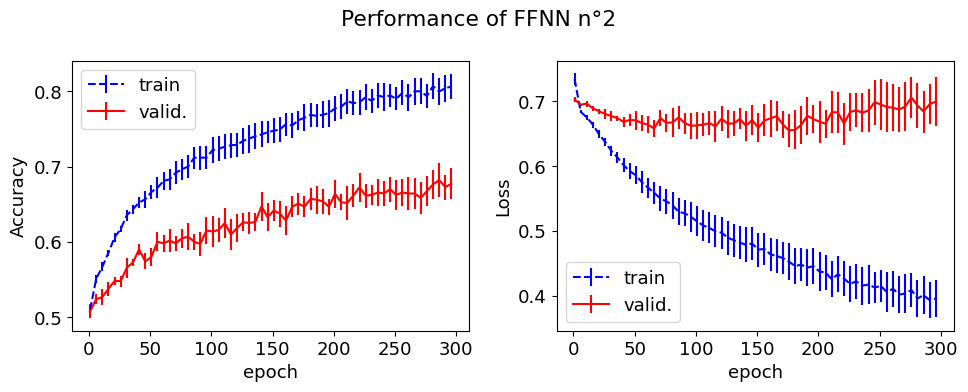

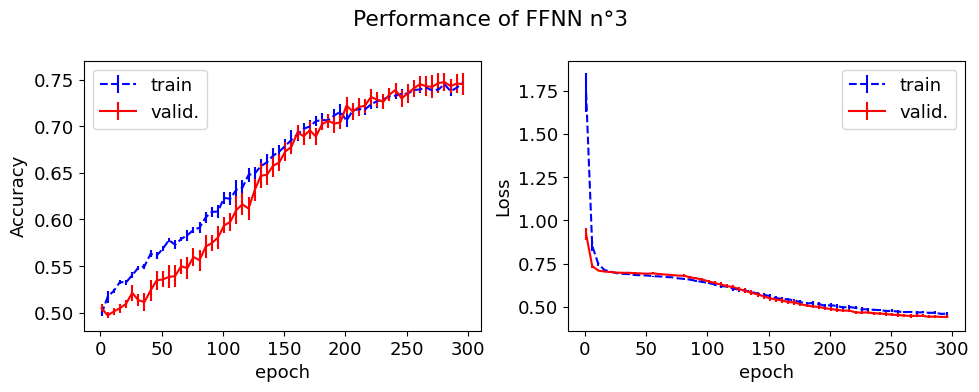

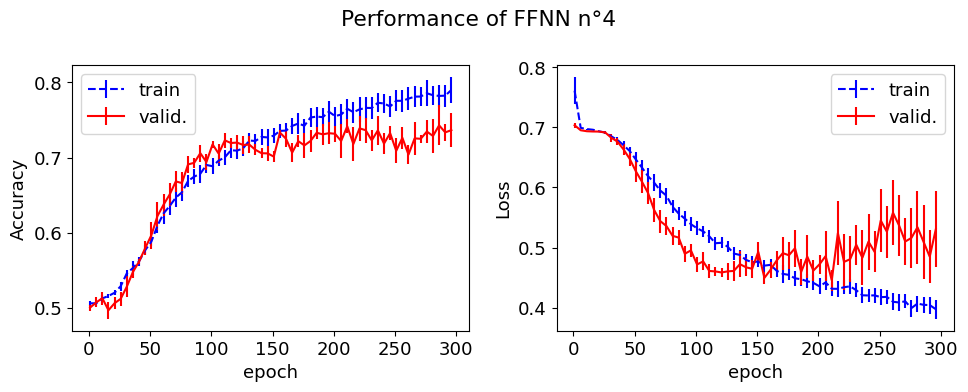

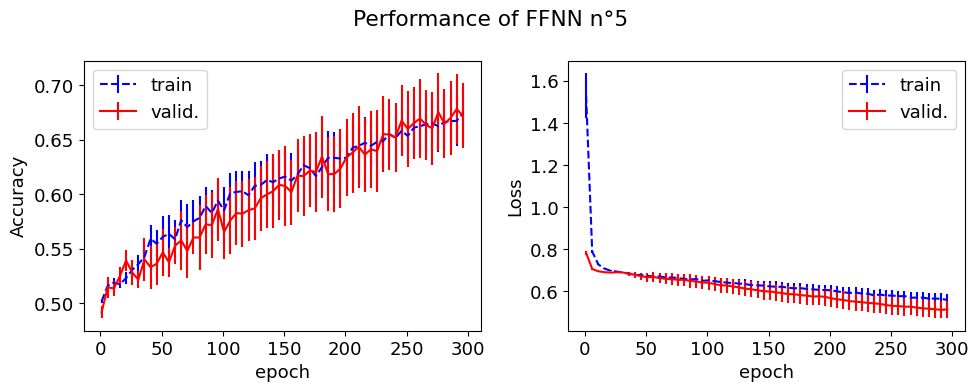

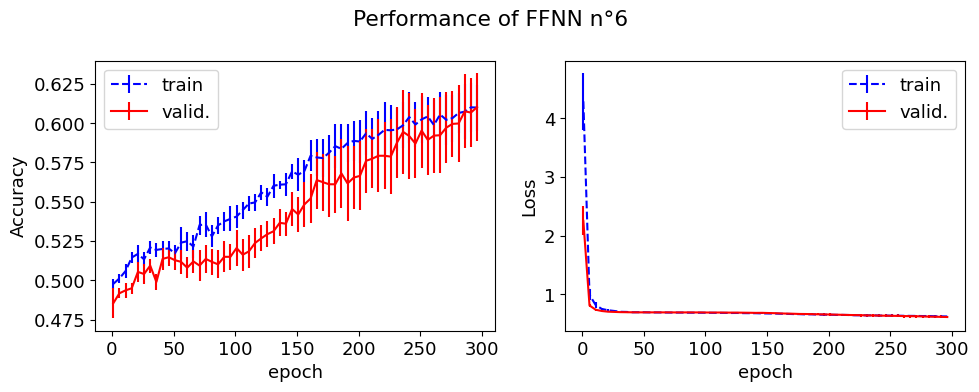

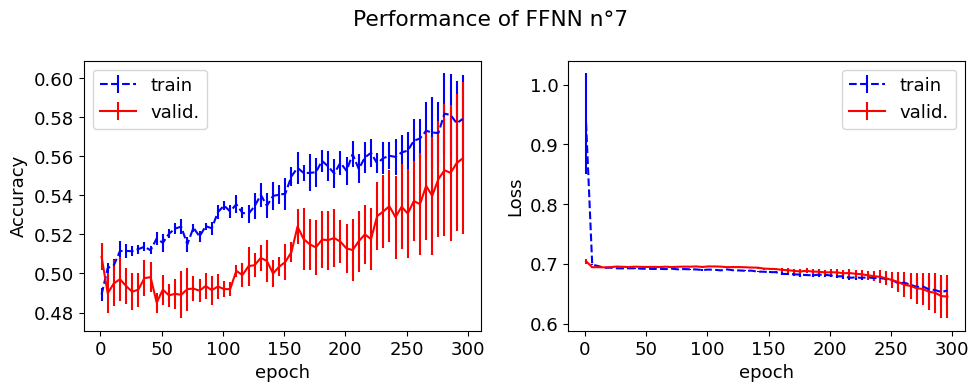

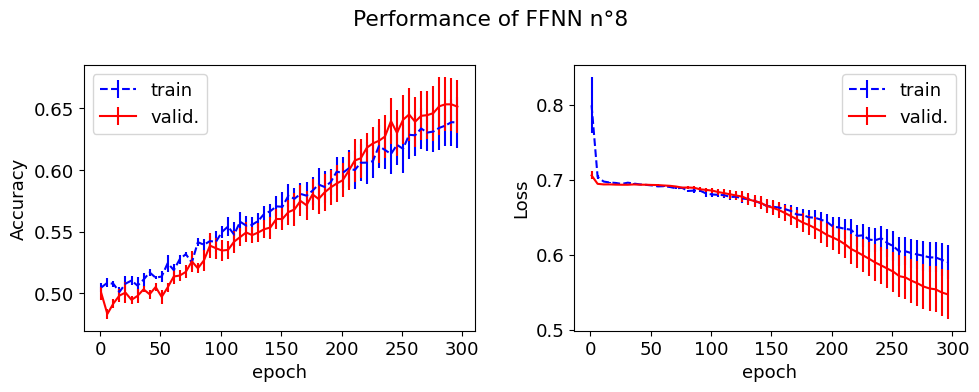

In [13]:
num_k = 5
val_acc_best4 = []

for i in range(8):
    train_acc, val_acc, train_loss, val_loss = cross_validate_ffnn(x_train, y_train, modelsHyperParam[i], kfold=num_k, epochs=nEpochs)
    val_acc_best4.append( np.mean(val_acc,axis=0)[-1] )
    PlotAccuracyAndLoss(train_acc,val_acc,train_loss,val_loss,i,tick=5, num_k = num_k)

In [14]:
#Show the sturcture of the 4 best NN models
result_nn = pd.DataFrame( [modelsHyperParam[i].values for i in range(8)] )
result_nn = result_nn.fillna("")
result_nn["accuracy"] = val_acc_best4
result_nn

,num_layers,units_0,activation,dropout,lr,optimizer,units_1,units_2,units_3,units_4,units_5,units_6,units_7,units_8,units_9,accuracy
0,7,40,elu,0.00,0.000141,adam,10,35,40,35,30,40,10,30,5.0,0.905333
1,6,20,selu,0.00,0.081772,adam,25,5,5,25,20,40,10,10,25.0,0.677333
2,2,35,elu,0.05,0.000006,adam,20,40,30,20,25,10,40,30,5.0,0.753067
3,8,30,selu,0.05,0.000098,adam,10,10,40,40,15,5,30,10,35.0,0.733333
4,3,5,selu,0.10,0.000009,RMSprop,25,40,25,30,35,40,15,30,30.0,0.688800
5,2,20,elu,0.05,0.001732,nadam,5,30,5,15,20,30,10,35,35.0,0.617867
6,6,5,leaky_relu,0.05,0.010218,nadam,5,25,5,5,5,25,15,5,,0.558933
7,5,20,elu,0.05,0.001640,adamax,10,20,5,25,25,15,35,35,40.0,0.649867


In [15]:
def PlotPred(clf=GradientBoostingClassifier(), show=False, ffnn=False, ax_compare=None, title=None, show_tree=False, x_train = x_train, y_train = y_train, x_test = x_test, y_test = y_test):


    if ffnn:
        errors=(1-clf.evaluate(x_test, y_test, verbose=0)[-1])
        accuracy=clf.evaluate(x_test, y_test, verbose=0)[-1]
    else:
        errors=(1-clf.score(x_test, y_test))
        accuracy=clf.score(x_test, y_test)

    if show and title==None: print("errors: {:.2f}%   Accuracy={:.3f}".format(100*errors,accuracy))
    S=50
    dx = 1
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,L))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:2] = [x_seq[i],x_seq[j]]
            q+=1


    if show:
        if ffnn:
            y_plot= clf.predict(x_plot)
        else:
            y_plot= clf.predict(x_plot)
        #fig,AX = plt.subplots(1,2,figsize=(8.2,4))
        if title != None and ax_compare != None:
            #fig_compare,AX = plt.subplots(1,1,figsize=(3,3))
            scat(ax_compare, x_plot[:],y_plot,s=dx,title=title)
            #plt.close()
        else:
            fig,AX = plt.subplots(1,2,figsize=(8.2,4))
            scat(AX[0],x_plot[:],y_plot,s=dx,title="predicted")
            scat(AX[1],x_train[:],y_train,title="training set")
            fig.tight_layout()
            plt.show()

    if show_tree:
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)

        fig, AX = plt.subplots(2,1,figsize=(12, 5))
        for i in range(min(2,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=400, pad_inches=0.02)
        plt.show()

    if title == None:
        return errors, accuracy

In [16]:
best_hp_nn = modelsHyperParam[0]
best_ffnn  = build_ffnn(modelsHyperParam[0])
best_ffnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 40)             │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           410 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 35)             │           385 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 40)             │         1,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 35)             │         1,435 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 30)             │         1,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 40)             │         1,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,231 (24.34 KB)

 Trainable params: 6,231 (24.34 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
best_ffnn.fit(x, y, epochs = nEpochs, batch_size = 20, validation_data = (x_test, y_test), verbose=0)

errors: 2.24%   Accuracy=0.978
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


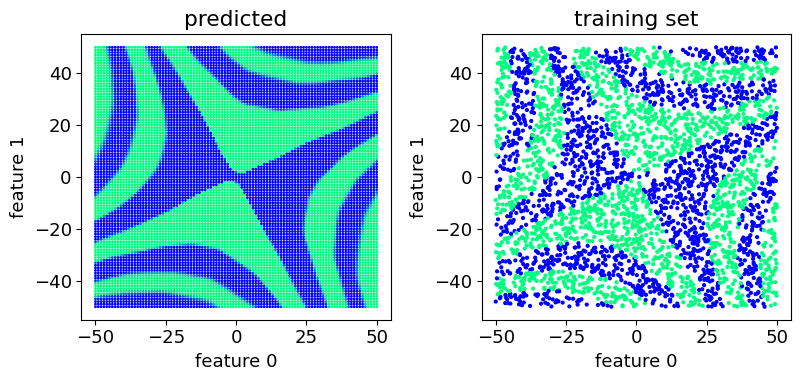

(0.02240002155303955, 0.9775999784469604)

In [18]:
PlotPred(best_ffnn, show=True, ffnn=True, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

## For XGBoost

In [ ]:
# create model
estimator = XGBClassifier( seed=1, objective= 'binary:logistic', importance_type="gain", nthread=4 )

# define the grid search parameters
parameters = {'reg_lambda': [1, 10, 50],
              'gamma': [0,0.01,0.1,0.2,0.5],
              'n_estimators': range(60, 220, 40)
              # 'max_depth' :
              # 'learning_rate' :
             }

# actual gridsearch
grid_search = GridSearchCV(estimator=estimator, param_grid=parameters, scoring = 'accuracy', n_jobs = -1, cv = 10, verbose=0)
grid_result = grid_search.fit(x_train, y_train)

# saving info about gridsearch results in a dataframe in descending order of accuracy
results_xgb = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
results_xgb = results_xgb.sort_values(by=['Accuracy'], ascending = False)
results_xgb = results_xgb.reset_index(drop=True)
results_xgb.head()


,gamma,n_estimators,reg_lambda,Accuracy
0,0.00,180,1,0.932533
1,0.00,140,1,0.932000
2,0.00,180,10,0.931200
3,0.01,180,1,0.931200
4,0.00,140,10,0.930933


errors: 6.56%   Accuracy=0.934


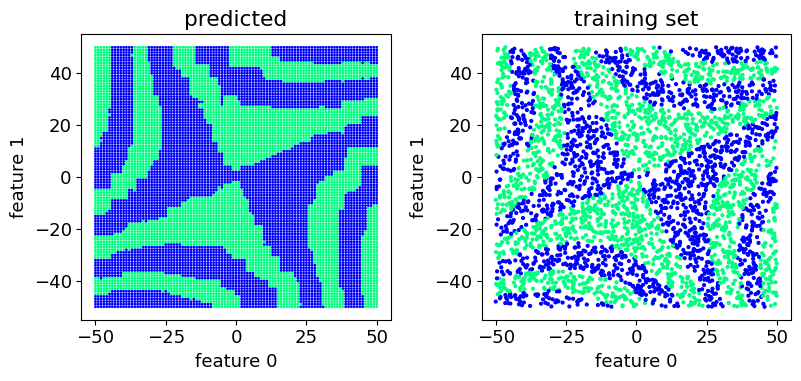

(0.06559999999999999, 0.9344)

In [86]:
n_est_xgboost = results_xgb['n_estimators'][0]
lambda_xgboost = results_xgb['reg_lambda'][0]
gamma_xgboost = results_xgb['gamma'][0]

model_xgboost = XGBClassifier(seed=1,objective='binary:logistic',importance_type="gain",
                          reg_lambda=lambda_xgboost,
                          gamma = gamma_xgboost,
                          n_estimators=n_est_xgboost,
                          #max_depth = max_depth_xgboost,
                          #learning_rate= lr_xgboost,
                          n_jobs = -1 )

classify(model_xgboost,show=True,x_train = x_train, y_train = y_train, x_test = x_test, y_test = y_test)

## Compare the results

In [87]:
# Fraction dataset used as training
fractions = np.arange(0.2,0.90,0.1)
fractions

array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

In [ ]:
def cross_validate_both(x, y, frac , k):

    accuracies_xgb = []
    accuracies_nn  = []

    for i in range(k):

        N_train = int(frac * len(x))
        x_trainA, x_testA, y_trainA, y_testA = train_test_split(x, y, train_size=N_train, shuffle=True)

        model_xgboost = XGBClassifier(seed=1,objective='binary:logistic',importance_type="gain",
                          reg_lambda=lambda_xgboost,
                          gamma = gamma_xgboost,
                          n_estimators=n_est_xgboost,
                          #max_depth = max_depth_xgboost,
                          #learning_rate= lr_xgboost,
                          n_jobs = -1 )

        model_xgboost.fit(x_trainA,y_trainA)
        accuracy_xgb=model_xgboost.score(x_testA, y_testA)



        model_nn = build_ffnn(best_hp_nn)
        fit_nn = model_nn.fit(x_trainA, y_trainA, validation_data=(x_testA, y_testA), epochs=20, batch_size=50, verbose=0)
        accuracy_nn = fit_nn.history['val_accuracy'][-1]

        accuracies_nn.append(accuracy_nn)
        accuracies_xgb.append(accuracy_xgb)

    return accuracies_xgb, accuracies_nn

In [89]:
# parallelized version
def cross_validate_both(x, y, frac, k,):

    def train_iteration(_):
        N_train = int(frac * len(x))
        x_trainA, x_testA, y_trainA, y_testA = train_test_split(x, y, train_size=N_train, shuffle=True)

        # Train XGBoost
        model_xgboost = XGBClassifier(seed=1, objective='binary:logistic', importance_type="gain",
                                      reg_lambda=lambda_xgboost, gamma=gamma_xgboost,
                                      n_estimators=n_est_xgboost, n_jobs=-1)
        model_xgboost.fit(x_trainA, y_trainA)
        accuracy_xgb = model_xgboost.score(x_testA, y_testA)

        # Train Neural Network
        model_nn = build_ffnn(best_hp_nn)
        fit_nn = model_nn.fit(x_trainA, y_trainA, validation_data=(x_testA, y_testA),
                              epochs=20, batch_size=50, verbose=0)
        accuracy_nn = fit_nn.history['val_accuracy'][-1]

        return accuracy_xgb, accuracy_nn

    results = Parallel(n_jobs=-1)(delayed(train_iteration)(i) for i in range(k))

    accuracies_xgb, accuracies_nn = zip(*results)
    return list(accuracies_xgb), list(accuracies_nn)

In [90]:
accuracy_mean_xgboost = []
accuracy_std_xgboost  = []
accuracy_mean_nn = []
accuracy_std_nn  = []

for frac in fractions:

    accuracies_xgb, accuracies_nn = cross_validate_both(x, y, frac , k=5)

    accuracy_mean_xgboost.append( np.mean(accuracies_xgb) )
    accuracy_std_xgboost.append(  np.std(accuracies_xgb)  )
    accuracy_mean_nn.append( np.mean(accuracies_nn) )
    accuracy_std_nn.append(  np.std(accuracies_nn)  )

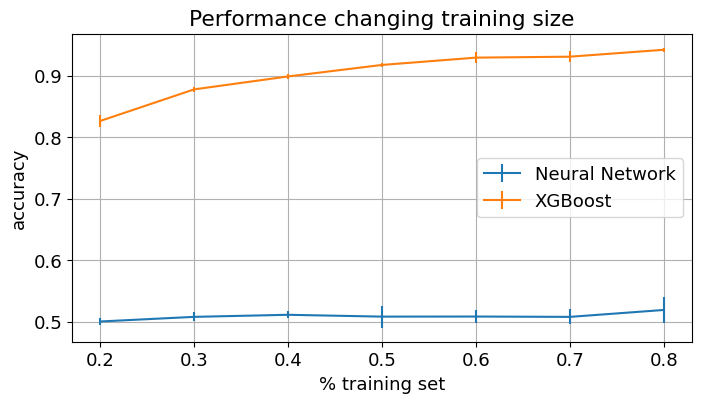

In [91]:
fig, ax= plt.subplots(1,1,figsize=(8,4))
ax.errorbar(x=fractions, y=accuracy_mean_nn, yerr=accuracy_std_nn, label='Neural Network')
ax.errorbar(x=fractions, y=accuracy_mean_xgboost, yerr=accuracy_std_xgboost, label='XGBoost')
ax.set_title('Performance changing training size')
ax.set_xlabel('% training set')
ax.set_ylabel('accuracy')
ax.grid()
ax.legend()
plt.show()

In [ ]:
fractions_prime = np.arange(0.2,0.9,0.2)
fractions_prime

In [ ]:
for frac in fractions_prime:
    N_train = int(frac * len(x))
    x_trainA, x_testA, y_trainA, y_testA = train_test_split(x, y, train_size=N_train, shuffle=True)

    model_xgboost = XGBClassifier(seed=1,objective='binary:logistic',importance_type="gain",
                      reg_lambda=lambda_xgboost,
                      gamma = gamma_xgboost,
                      n_estimators=n_est_xgboost,
                      #max_depth = max_depth_xgboost,
                      #learning_rate= lr_xgboost,
                      n_jobs = -1 )
    model_nn = build_ffnn(best_hp_nn)

    fig,ax_both = plt.subplots(1,2,figsize=(8.2,4))
    fig.suptitle(f"with {100*frac:.0f}% training set")
    classify(model_xgboost, ax_compare=ax_both[0], show=True, title=f"XGBoost", x_train=x_trainA, y_train=y_trainA, x_test=x_testA, y_test=y_testA)
    ax_nn=classify(model_nn, ax_compare=ax_both[1], show=True, ffnn=True, title=f"Neural Network", x_train=x_trainA, y_train=y_trainA, x_test=x_testA, y_test=y_testA)
    plt.tight_layout()
    print("\n")
    plt.show()